In [101]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
from scipy.special import softmax
from pathlib import Path

In [128]:
def load_results_from_logs(ex_ids: list):
    all_results = []
    for ex_id in ex_ids:
        path = f"./../logs/{ex_id}/"
        with open(path + "metrics.json") as fp:
            results = json.load(fp)
        with open(path + "config.json") as fp:
            config = json.load(fp)
        attr_path = sorted(Path(path).iterdir(), key= lambda x: len(str(x)))[-1]
        with open(attr_path) as fp:
            attributions = json.load(fp)
        result_dict = {
            'experiment_name': config["name"],
            "attribution_name": config["attribution_method"]["name"],
            "tpn": results["tpn"]["values"],
            "tps": results["tps"]["values"],
            "attribution_list": attributions,
            'merged_attributions': np.concatenate([d['attribution_values'] for d in attributions])#.astype(np.half)
        }
        all_results.append(result_dict)
    return all_results

def generate_tpn_tps_tables(all_results):
    names = ["Methods"] + [r["attribution_name"] for r in all_results] + ["#Nones"]
    table_tpn = PrettyTable(names)
    table_tps = PrettyTable(names)

    for result in all_results:
        row_name = result["attribution_name"]
        row_values_tpn = []
        row_values_tps = []

        nones_tpn, nones_tps = np.sum(np.array(result["tpn"]) == None), np.sum(np.array(result["tps"]) == None)
        for result2 in all_results:
            tpn1, tps1 = np.array(result["tpn"]), np.array(result["tps"])
            tpn2, tps2 = np.array(result2["tpn"]), np.array(result2["tps"])
            none_idx_tpn = np.logical_or(tpn1 == None, tpn2 == None)
            none_idx_tps = np.logical_or(tps1 == None, tps2 == None)
            row_values_tpn.append(np.sum(tpn1[np.invert(none_idx_tpn)] < (tpn2[np.invert(none_idx_tpn)])))
            row_values_tps.append(np.sum(tps1[np.invert(none_idx_tps)] < (tps2[np.invert(none_idx_tps)])))

        table_tpn.add_row([row_name, *row_values_tpn, nones_tpn])
        table_tps.add_row([row_name, *row_values_tps, nones_tps])
    return table_tpn, table_tps

def plot_table_as_heatmap(table: PrettyTable):
    labels_y, values = [], []
    for row in table.rows:
        a, *b = row[:-1]
        labels_y.append(a)
        values.append(b)

    ax = sns.heatmap(values, annot=True, xticklabels=labels_y, yticklabels=labels_y, fmt='.0f',cmap='Purples')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.xaxis.tick_top()
    plt.show()

def plot_attribution_hists(all_results):
    fig, axes = plt.subplots(len(all_results),1, figsize=(10,15))
    for ax, result in zip(axes, all_results):
        ax.set_title(result['attribution_name'])
        x = result['merged_attributions']

        sns.histplot(ax=ax, data=x, bins=100, kde=True)
    plt.show()

def plot_tpn_tps_scatter(all_results):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,15))
    for result in all_results:
        name = result['attribution_name']
        sns.scatterplot(ax=ax1, data=result['tpn'], label=name)
        sns.scatterplot(ax=ax2, data=result['tps'], label=name)

    ax1.legend()
    ax2.legend()
    plt.show()

### Load dataset and results from first experiments
The dataset contains the index in the original imdb dataset, the text, the tokenized texts, the
input ids and the label. It consists of 1000 observations.
The results contain the index in the original imdb dataset, the attribution values of the
attribution method on that observation and the TPN/TPS of these attributions.
As Model Distilbert is used. Before saving, it was optimized and quantized for faster inference.
For a performance comparison see notebooks/run_distilbert_full_vs_quantized.ipynb.

In [143]:
ex_ids = [39,  #random
          40,  #kernel shap
          41,  #lime
          53,  #ngopt(tpn)
          # 56, #ngopt(tps)
          ]

all_results = load_results_from_logs(ex_ids=ex_ids)

In [144]:
table_tpn, table_tps = generate_tpn_tps_tables(all_results=all_results)

print(table_tpn)
print(table_tps)

+---------------------------+---------------------------+-------------+------+-----------+--------+
|          Methods          | random-attribution-values | kernel-shap | lime | ngopt-tpn | #Nones |
+---------------------------+---------------------------+-------------+------+-----------+--------+
| random-attribution-values |             0             |     284     |  67  |    155    |   0    |
|        kernel-shap        |            716            |      0      |  66  |    527    |   0    |
|            lime           |            860            |     861     |  0   |    826    |   73   |
|         ngopt-tpn         |            845            |     473     | 101  |     0     |   0    |
+---------------------------+---------------------------+-------------+------+-----------+--------+
+---------------------------+---------------------------+-------------+------+-----------+--------+
|          Methods          | random-attribution-values | kernel-shap | lime | ngopt-tpn | #Nones |



### Plot as Heatmap

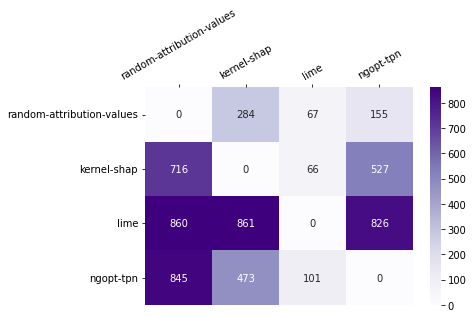

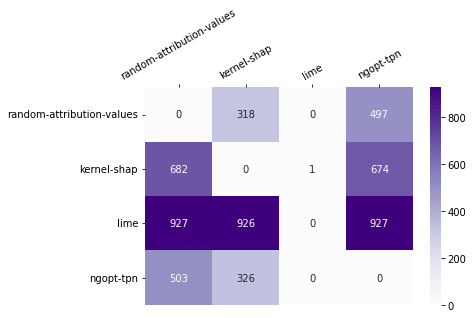

In [145]:
plot_table_as_heatmap(table_tpn)
plot_table_as_heatmap(table_tps)

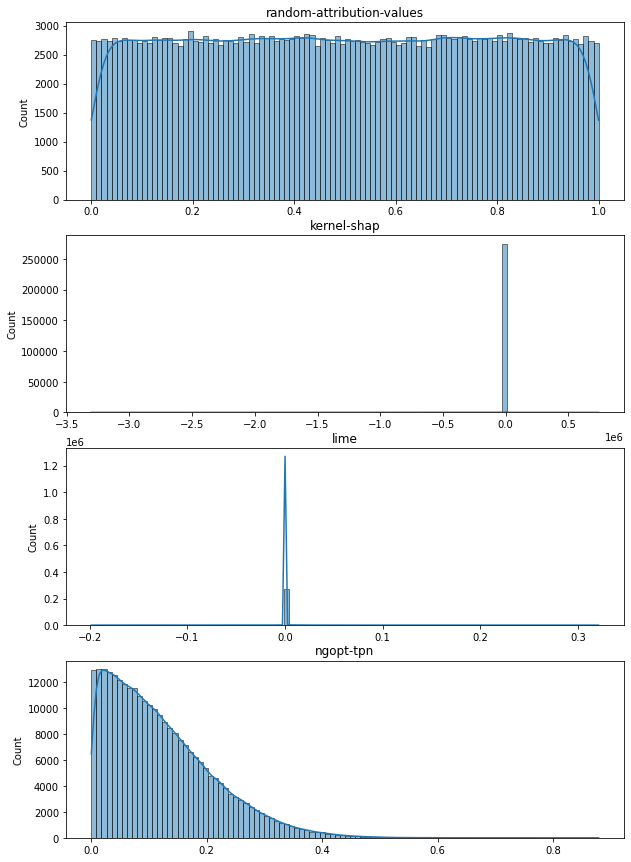

In [146]:
plot_attribution_hists(all_results)

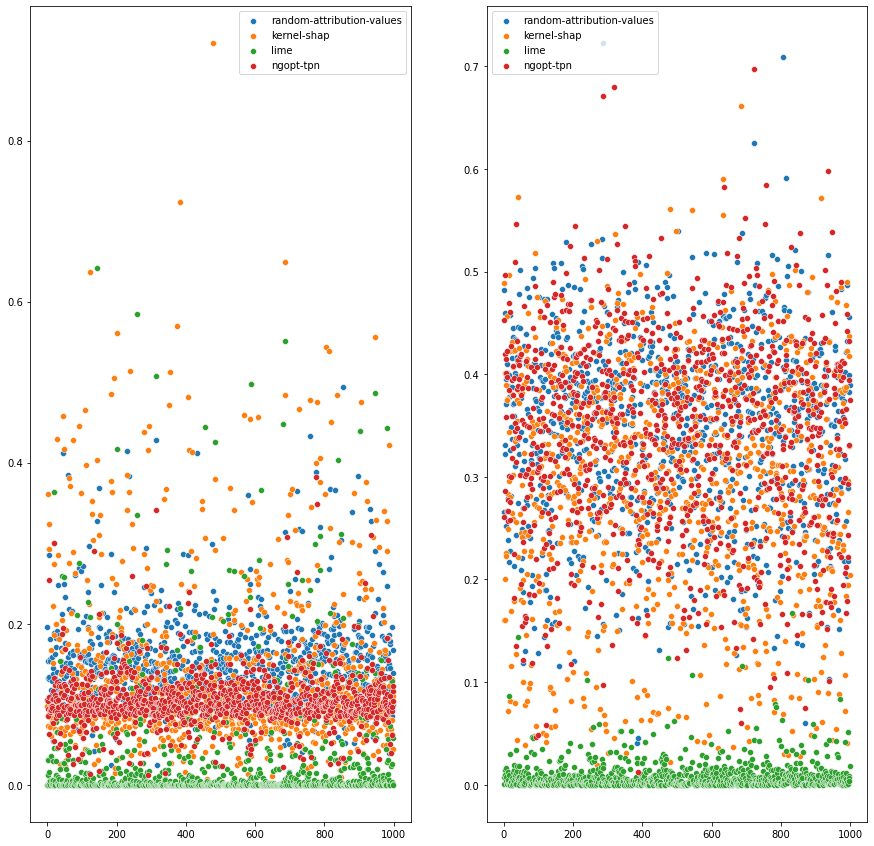

In [147]:
plot_tpn_tps_scatter(all_results)